In [2]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

## 1. Get the Data 

In [11]:
train = pd.read_csv('data/train.csv', names=['Word', 'Label'])
test = pd.read_csv('data/test.csv', names=['Word'])

## 2. Feature Engineering

In [12]:
def countDoubles(word):
    l = [let for let in word.lower()]
    return len([(x,y) for x,y in itertools.izip(l, l[1:]) if x == y])

def build_features(data):
    data['Word'] = data['Word'].apply(lambda word: word.decode('utf-8'))
    data['Length'] = data['Word'].apply(lambda word: len(word))
    
    vowels = [ 'а',  'я', 'ё', 'у','е', 'о', 'э', 'ю', 'и', 'ы', 'Ё', 'У', 'Е', 'Ы','А', 'О', 'Э', 'Ю', 'И', 'Я' ]
    vowels = [let.decode('utf-8') for let in vowels]
    data['Vowels'] = data['Word'].apply(lambda word: len([letter for letter in word if letter in vowels]))
    data['Consonants'] = data['Length'] - data['Vowels']
    
    data['is_lower'] = data['Word'].apply(lambda word: int( word[0] >= 'а'.decode('utf-8')))
    
    data['Double'] = data['Word'].apply(lambda word: countDoubles(word))

In [13]:
build_features(train)
build_features(test)

## 3. Cross validation 

In [14]:
cols = train.columns.drop(['Word', 'Label'])

In [17]:
train[cols][:3]

,Length,Vowels,Consonants,is_lower,Double
0,8,4,4,0,1
1,3,2,1,0,1
2,5,3,2,0,1


In [19]:
from sklearn.cross_validation import train_test_split

xtrain, xcv, ytrain, ycv = train_test_split(train[cols], train['Label'], test_size = 0.1,  random_state = 10)
xtrain, xcv = map(lambda x: pd.DataFrame(x, columns=cols), [xtrain, xcv])
ytrain, ycv = map(lambda x: pd.DataFrame(x, columns=['Label']), [ytrain, ycv])

#### a) Try Logistic Regression 

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(xtrain, ytrain)
predictionLR = lr.predict_proba(xcv)

In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ycv, predictionLR[:,1])

0.7924645218185653

#### b) Try RF Classification 

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 10)
rf.fit(xtrain, ytrain)
predictionRF = rf.predict_proba(xcv)

roc_auc_score(ycv, predictionRF[:,1])

0.80388159557788397

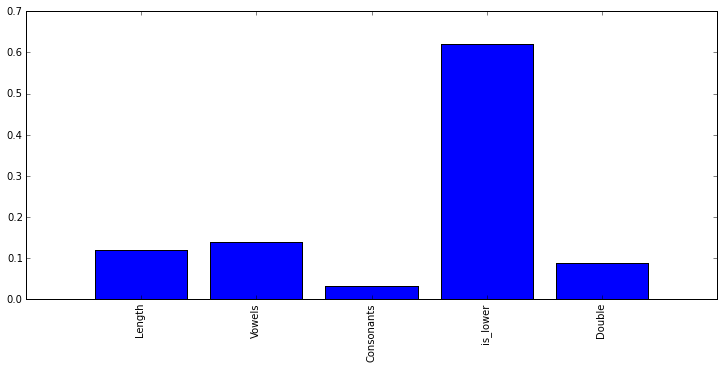

In [24]:
# Show feature importances
import pylab
import scipy

importances = rf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

labels = [cols[i] for i in indices.tolist()]
x = scipy.array(indices)
y = scipy.array(importances[indices])
f = pylab.figure(figsize=(12,5))
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x, y, align='center')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
f.show()

## 4. Make prediction 

In [25]:
rf = RandomForestClassifier(
                n_estimators=1000,
                criterion='gini',
                oob_score=True,
                max_depth=5,  # Need to be align
                max_features=4,  # Need to be align
                random_state=42, # Need to be align
                n_jobs=-1 )
rf.fit(train[cols], train['Label'])
submitRF = rf.predict_proba(test[cols])

In [28]:
submit = pd.DataFrame()
submit['Id'] = xrange(len(test))
submit['Answer'] = submitRF[:, 1]
submit[:5]

,Id,Answer
0,0,0.024880
1,1,0.357864
2,2,0.316122
3,3,0.316122
4,4,0.315904


In [29]:
submit.to_csv('submit.csv', index = False)